<a href="https://colab.research.google.com/github/tylaar1/Quantum-GANs/blob/main/BaseModel_Quantum_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports + Preamble

# testing out if this ssh madness actually works

In [17]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# !pip install pennylane
import pennylane as qml

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

Set the random seed for reproducibility

In [19]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 1) Data Loading + Pre-Processing

a) Create class that does the loading and pre-processing of the MNIST data

b) create class instance to load in the MNIST data

c) create data loader object

## 1a) Create class that does the loading and pre-processing of the MNIST data

- `__init__`: stores MNIST filepath, data transformation and filtered MNIST dataframe
- `filter_by_label`: filters for images with the label = [insert [0,9] label]
- `__len__`: returns total number of images in the filtered dataset
- `__getitem__`: retrieves specific image and its label from the dataset based on the provided index. It normalises pixel values, reshapes the image, applies any specified transformations & returns the processed image and label

In [20]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, filepath, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            label (int [0,9], optional): Filter for MNIST images with said specified label.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            """
        self.filepath = filepath
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.filepath)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

## 1b) create class instance to load in the MNIST data
This data is filtered by the label kwarg in the DigitDataset class

In [21]:
transform_to_pytorch_tensor = transforms.Compose([transforms.ToTensor()])

dataset = DigitsDataset(
    filepath = "MNIST_images.tra",
    transform = transform_to_pytorch_tensor
)

see what's in our class instance

In [22]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.6250, 1.0000, 0.3750, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4375, 1.0000, 0.5000, 1.0000, 0.3125, 0.0000, 0.0000],
          [0.0000, 0.6875, 1.0000, 0.0000, 0.3750, 0.8750, 0.1875, 0.0000],
          [0.0000, 0.7500, 0.7500, 0.0000, 0.0000, 0.6875, 0.6875, 0.0000],
          [0.0000, 0.7500, 0.7500, 0.0000, 0.0000, 0.5000, 0.7500, 0.0000],
          [0.0000, 0.4375, 0.9375, 0.0625, 0.0000, 0.8125, 0.6875, 0.0000],
          [0.0000, 0.0000, 1.0000, 0.5000, 0.6250, 0.9375, 0.1875, 0.0000],
          [0.0000, 0.0000, 0.6250, 1.0000, 0.9375, 0.1875, 0.0000, 0.0000]]]),
 0)

in the above output we can see the feature map and the label

display the first 8 images in the dataset class instance

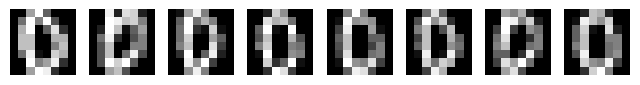

In [23]:
IMAGE_SIZE = 8
reshaped_image_shape = (IMAGE_SIZE, IMAGE_SIZE)

plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(reshaped_image_shape)
    plt.subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

to change the digits printed, change the label kwarg in the DigitDataset class

## 1c) create data loader object

dataloaders efficiently load date in batches during training

In [46]:
BATCH_SIZE = 1

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

In [48]:
print(f'there are {len(dataloader)} images in the dataloader')

there are 375 images in the dataloader


# 2) Model Building

a) Build class for the classical discriminator

b) Building the quantum generator
- i) define the quantum variables
- ii) define the quantum device
- iii) define the qunatum circuit
- iv) define the partial measurement process
- v) create quantum generator class to use during training

## 2a) Build class for the classical discriminator

- fully connected NN with two hidden layers
- sigmoid output => probability of an input being classified as real

In [25]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__() # calls the constructer of the parent class (nn.Module)

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(IMAGE_SIZE * IMAGE_SIZE, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## 2b) building the quantum generator

Quantum generator consists of `n_generators` sub-generators, each comprised of `n_qubits` qubits

Sub-generator circuit architecture:

<img src="https://pennylane.ai/_images/qcircuit.jpeg" width="500">

---

i) **state embedding**: a latent vector, $z \in \mathbb{R}^N$, is sampled from a uniform distn in the interval $[0, \pi/2)$ and sent to all sub-generators

$z$ --> $|z\rangle$ (state embedding) by applying the RY gates. Each element of z determines the rotation angle of the RY gate.

---

ii) **parameterised layers**: a set of parameterised RY gates apply LINEAR (because they're unitary) TRANSFORMATIONS to the quantum state, followed by control Z gates (to introduce entanglement). This layer is repeated `q_depth` times.

---

iii) **Non-linear transform**: For non-simple generative tasks we need a non-linearity.

Ancillary qubits and partial measurements are used to introduce NON-LINEARITY.

Partial measurement: measure ONLY the ancillary qubits. This collapses them into classical values. We don't care about those values though so just discard them.

The act of measuring the ancillary qubits and collapsing them to classical values forces a non-linear transformation on the remaining qubits. We then measure these remaining qubits to obtain sub-generator output $\boldsymbol{g^{(i)}}$, the output for a given patch of pixels. Normalisation, causes the sum of all its elements to sum to 1

---

iv) **post processing**: all the elements summing to one makes it difficult to map them to pixel intensities

$\tilde{x}(i) = \frac{g(i)}{\max_k g(i)_k}$

this solves the issue by scaling it so the largest values becomes 1 and all other values scale proportionally

---

### 2b) i) define quantum variables - as per the diagram in the above markdown

potentially add grid search for these hyperparams

In [26]:
n_qubits = 5
n_a_qubits = 1
q_depth = 6
n_generators = 4

### 2b) ii) define the quantum device

In [27]:
dev = qml.device("lightning.qubit", wires=n_qubits)

# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2b) iii) define the quantum circuit

In [28]:
@qml.qnode(dev, diff_method="parameter-shift") # recall the parameter shift differentiation method from lectures, differentiation needed for backprop
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # State embedding
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))

### 2b) iv) define the partial measurement process

In [29]:
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

### 2b) v) create a quantum generator class to use during training

- `__init__`: initialises the quantum generator, holds container for the learnable weights that will updated during training (`self.q_params`)
- `forward`: iterates over `self.q_params` list which contains the paramters for each sub-generator used to generate the output patches, the patches are concatenated together to form a full image

In [30]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, input_batch):
        # Initialise empty pytorch Tensor to store the generated images - x.size(0) is the batch size.
        images = torch.Tensor(input_batch.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            PATCH_SIZE = 2 ** (n_qubits - n_a_qubits)
            patches = torch.Tensor(0, PATCH_SIZE).to(device) # initialise empty pytorch tensor to store the generated patches
            for elem in input_batch:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

# 3) Training + Evaluation

a) define learning rates and number of training iterations

b) execute training process

c) evaluation: plot how the generated images evolved throughout training

## 3a) define learning rates and number of training iterations

In [31]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 300  # Number of training iterations

In [45]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_distribution_similarity(real_images, fake_images):
    """
    Calculate a distribution similarity score between real and generated images.
    Lower score means distributions are more similar.
    
    Args:
        real_images: Tensor of shape [batch_size, 1, height, width]
        fake_images: Tensor of shape [batch_size, 1, height, width]
    
    Returns:
        similarity_score (float)
    """
    # Flatten images to feature vectors
    real_features = real_images.view(real_images.size(0), -1).cpu().detach().numpy()
    fake_features = fake_images.view(fake_images.size(0), -1).cpu().detach().numpy()
    
    # Calculate mean vectors
    mu1 = real_features.mean(axis=0)
    mu2 = fake_features.mean(axis=0)
    
    # Calculate squared difference between means
    mean_diff = np.sum((mu1 - mu2) ** 2.0)
    
    # Handle covariance calculation (need at least 2 samples for proper covariance)
    if real_features.shape[0] > 1 and fake_features.shape[0] > 1:
        # Calculate covariance matrices
        sigma1 = np.cov(real_features, rowvar=False)
        sigma2 = np.cov(fake_features, rowvar=False)
        
        # Add small epsilon to diagonal for numerical stability
        eps = 1e-6
        sigma1 = sigma1 + np.eye(sigma1.shape[0]) * eps
        sigma2 = sigma2 + np.eye(sigma2.shape[0]) * eps
        
        # Calculate matrix sqrt product
        try:
            covmean = sqrtm(sigma1.dot(sigma2))
            if np.iscomplexobj(covmean):
                covmean = covmean.real
            
            # Complete similarity score with covariance term
            similarity_score = mean_diff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        except:
            # Fallback if matrix operations fail
            similarity_score = mean_diff
    else:
        # If we don't have enough samples for covariance, just use mean difference
        similarity_score = mean_diff
    
    return similarity_score

## 3b) Execute training process

In [50]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((BATCH_SIZE,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((BATCH_SIZE,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Counters
counter = 0
epoch = 0

# For plotting
results = [] # images (pytorch tensors of pixel values)
discriminator_loss = []
generator_loss = []
similarity_scores = []  # For tracking our distribution similarity metric

# Cache real images batch for similarity calculation to avoid reloading for each iteration
real_batch = []
for j in range(min(10, len(dataset))):
    real_batch.append(dataset[j][0])
real_images_cache = torch.stack(real_batch).view(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

# Total number of images in dataset
total_images = len(dataloader)

while True:
    epoch += 1
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    
    print(f"\nStarting Epoch {epoch}")
    
    for i, (data, _) in enumerate(dataloader):
        # Data for training the discriminator
        data = data.reshape(-1, IMAGE_SIZE * IMAGE_SIZE)
        real_data = data.to(device)

        # Noise following a uniform distribution in range [0,pi/2)
        noise = torch.rand(BATCH_SIZE, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels) # discriminator loss = errD
        errD_fake = criterion(outD_fake, fake_labels) # generator loss = errG
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        # Store loss values
        discriminator_loss.append(errD.item())
        generator_loss.append(errG.item())
        
        # Calculate and store similarity score at every iteration
        with torch.no_grad():
            # Use fixed noise for consistent comparison across iterations
            test_images = generator(fixed_noise).view(8, 1, IMAGE_SIZE, IMAGE_SIZE).cpu().detach()
            
            # Calculate similarity
            sim_score = calculate_distribution_similarity(real_images_cache, test_images)
            similarity_scores.append(sim_score)
        
        # Add to epoch average
        epoch_d_loss += errD.item()
        epoch_g_loss += errG.item()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}, Similarity Score: {sim_score:.4f}')
            
            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    
    # Calculate average losses for this epoch
    avg_d_loss = epoch_d_loss / total_images
    avg_g_loss = epoch_g_loss / total_images
    
    # Calculate final similarity score for the epoch (using the most recent value)
    final_sim_score = similarity_scores[-1]
    
    print(f"Epoch {epoch} completed | Avg D Loss: {avg_d_loss:.4f} | Avg G Loss: {avg_g_loss:.4f} | Similarity Score: {final_sim_score:.4f}")
    
    if counter == num_iter:
        break

print(f"\nTraining completed after {epoch} epochs and {counter} iterations.")

# Now you can plot your metrics and generate final images


Starting Epoch 1
Iteration: 10, Discriminator Loss: 1.371, Generator Loss: 0.704, Similarity Score: 13.6411
Iteration: 20, Discriminator Loss: 1.340, Generator Loss: 0.712, Similarity Score: 13.6141
Iteration: 30, Discriminator Loss: 1.329, Generator Loss: 0.716, Similarity Score: 13.4974
Iteration: 40, Discriminator Loss: 1.302, Generator Loss: 0.710, Similarity Score: 13.2770
Iteration: 50, Discriminator Loss: 1.289, Generator Loss: 0.713, Similarity Score: 12.7417
Iteration: 60, Discriminator Loss: 1.300, Generator Loss: 0.689, Similarity Score: 12.2696
Iteration: 70, Discriminator Loss: 1.260, Generator Loss: 0.706, Similarity Score: 11.8725
Iteration: 80, Discriminator Loss: 1.243, Generator Loss: 0.712, Similarity Score: 11.4216
Iteration: 90, Discriminator Loss: 1.232, Generator Loss: 0.708, Similarity Score: 10.6038
Iteration: 100, Discriminator Loss: 1.263, Generator Loss: 0.675, Similarity Score: 9.9171
Iteration: 110, Discriminator Loss: 1.221, Generator Loss: 0.691, Simila

## 3c) plot how the loss and generated images evolved throughout training

In [54]:
print(type(similarity_scores))
print(len(similarity_scores))
print(similarity_scores[:5])

<class 'list'>
300
[13.639073013678772, 13.643034701401344, 13.69376168237569, 13.626843033195374, 13.64271083704512]


In [56]:
discriminator_loss[0]

1.3669781684875488

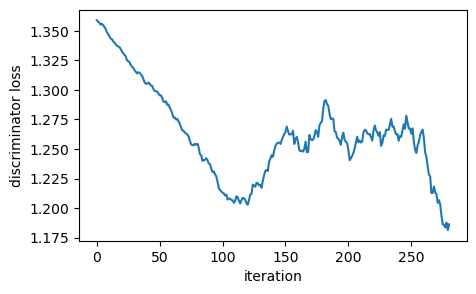

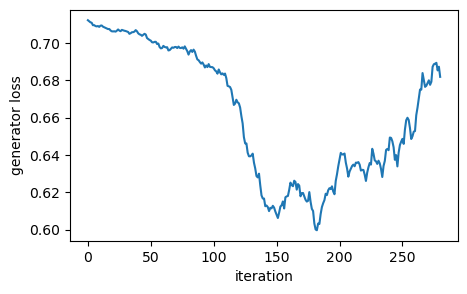

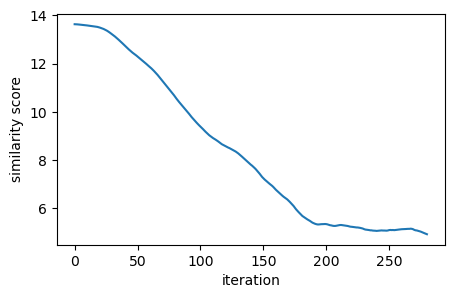

In [64]:
def rolling_average(arr, ROLLING_WINDOW_SIZE):
    np_arr = np.array(arr)
    cumsum = np_arr.cumsum()
    cumsum[ROLLING_WINDOW_SIZE:] -= cumsum[:-ROLLING_WINDOW_SIZE]
    return np.array((cumsum[ROLLING_WINDOW_SIZE - 1:] / ROLLING_WINDOW_SIZE))

# def plot_loss(loss_tensors, ylabel):
#     loss = np.array([l.item() for l in loss_tensors])
#     loss = rolling_average(loss, 20)
#     fig = plt.figure()
#     ax = fig.gca()
#     ax.plot(loss)
#     ax.set_ylabel(ylabel)
#     ax.set_xlabel('iteration')

def plot_metric(metric, ylabel):
    metric_roll_avg = rolling_average(metric, 20)
    # metric_roll_avg = metric # No rolling average for similarity scores
    fig = plt.figure(figsize=(5, 3))
    ax = fig.gca()
    ax.plot(metric_roll_avg)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('iteration')

plot_metric(discriminator_loss, 'discriminator loss')
plot_metric(generator_loss, 'generator loss')
plot_metric(similarity_scores, 'similarity score')

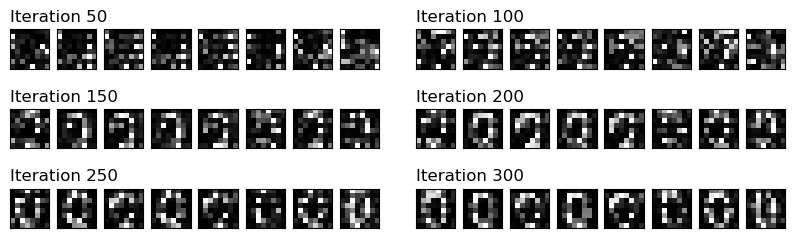

In [34]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

# trying quantitative metrics

In [43]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_distribution_similarity(real_images, fake_images):
    """
    Calculate a distribution similarity score between real and generated images.
    Lower score means distributions are more similar.
    
    Args:
        real_images: Tensor of shape [batch_size, 1, height, width]
        fake_images: Tensor of shape [batch_size, 1, height, width]
    
    Returns:
        similarity_score (float)
    """
    # Flatten images to feature vectors
    real_features = real_images.view(real_images.size(0), -1).cpu().detach().numpy()
    fake_features = fake_images.view(fake_images.size(0), -1).cpu().detach().numpy()
    
    # Calculate mean vectors
    mu1 = real_features.mean(axis=0)
    mu2 = fake_features.mean(axis=0)
    
    # Calculate squared difference between means
    mean_diff = np.sum((mu1 - mu2) ** 2.0)
    
    # Handle covariance calculation (need at least 2 samples for proper covariance)
    if real_features.shape[0] > 1 and fake_features.shape[0] > 1:
        # Calculate covariance matrices
        sigma1 = np.cov(real_features, rowvar=False)
        sigma2 = np.cov(fake_features, rowvar=False)
        
        # Add small epsilon to diagonal for numerical stability
        eps = 1e-6
        sigma1 = sigma1 + np.eye(sigma1.shape[0]) * eps
        sigma2 = sigma2 + np.eye(sigma2.shape[0]) * eps
        
        # Calculate matrix sqrt product
        try:
            covmean = sqrtm(sigma1.dot(sigma2))
            if np.iscomplexobj(covmean):
                covmean = covmean.real
            
            # Complete similarity score with covariance term
            similarity_score = mean_diff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        except:
            # Fallback if matrix operations fail
            similarity_score = mean_diff
    else:
        # If we don't have enough samples for covariance, just use mean difference
        similarity_score = mean_diff
    
    return similarity_score

In [44]:
# Example usage with multiple images
# For real images, get a small batch from your dataset
real_batch = []
for i in range(10):  # Get 10 real images
    real_batch.append(dataset[i][0])
real_images = torch.stack(real_batch).view(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

# For fake images, generate a batch or use multiple stored results
fake_batch = []
for i in range(min(10, len(results))):  # Get up to 10 fake images
    fake_batch.append(results[i][0])
fake_images = torch.stack(fake_batch).view(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

similarity_score = calculate_distribution_similarity(real_images, fake_images)
print(f"Distribution similarity score: {similarity_score:.4f}")

Distribution similarity score: 9.0415
